# Wstęp do uczenia maszynowego - Projekt 1
## Aleksander Malinowski | Damian Skowroński
___

### Wprowadzenie
W projekcie używamy zbioru danych [Chess king rook](https://www.apispreadsheets.com/datasets/115), który dotyczy zakończeń gier w szachy w przypadku gdy biała strona ma króla i wieżę, a czarnej pozostał tylko król.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('chess_king_rook_dataset.csv')
df.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result
0,a,1,b,3,c,2,draw
1,a,1,c,1,c,2,draw
2,a,1,c,1,d,1,draw
3,a,1,c,1,d,2,draw
4,a,1,c,2,c,1,draw


Jak widać mamy pozycje każdej z trzech figur, a zmienna opisywana _result_ mówi o tym, czy gra zakończyła się remisem (poprzez pat, lub przez zbicie wieży), lub w ilu ruchach od danej pozycji gra zakończyła się matem.

Sprawdzenie, czy są wartości "NA":

In [10]:
df.isna().sum()

white_king_file    0
white_king_rank    0
white_rook_file    0
white_rook_rank    0
black_king_file    0
black_king_rank    0
result             0
dtype: int64

Okazuje się, że nie, teraz dokładniejsze sprawdzenie, czy brakujące wartości nie kryją się pod innym oznaczeniem.

In [19]:
for column in df.columns:
    print(column, df[column].unique())


white_king_file ['a' 'b' 'c' 'd']
white_king_rank [1 2 3 4]
white_rook_file ['b' 'c' 'd' 'e' 'f' 'g' 'h' 'a']
white_rook_rank [3 1 2 4 5 6 7 8]
black_king_file ['c' 'd' 'e' 'f' 'g' 'h' 'a' 'b']
black_king_rank [2 1 3 4 5 6 7 8]
result ['draw' 'zero' 'one' 'two' 'three' 'four' 'five' 'six' 'seven' 'eight'
 'nine' 'ten' 'eleven' 'twelve' 'thirteen' 'fourteen' 'fifteen' 'sixteen']


Wszystkie wartości są sensowne dla szachów, czyli w zbiorze danych nie ma brakujących wartości. Wobec tego nie będzie potrzebna imputacja. Co ciekawe, można zauważyć, że pola białego króla ograniczają się do kwadratu 4x4.

### Encoding
Dla zmiennych określających linię na szachownicy, stosujemy _label encoding_. Natomiast dla zmiennej _result_ zamienimy tekstowe wartości na liczby, a wartości "draw" tymczasowo przypiszemy wartość -1 (ze świadomością, że mogą zaburzyć proces uczenia).

In [20]:
from sklearn.preprocessing import LabelEncoder

def encode_df(dataframe):
    le = LabelEncoder()
    for column in dataframe.columns:
        if 'file' in column:
            dataframe[column] = le.fit_transform(dataframe[column])
            dataframe[column] += 1
    return dataframe

df = encode_df(df)

In [21]:
def encode_results(string):
    if string == 'draw':
        string = -1
    elif string == 'zero':
        string = 0
    elif string == 'one':
        string = 1
    elif string == 'two':
        string = 2
    elif string == 'three':
        string = 3
    elif string == 'four':
        string = 4
    elif string == 'five':
        string = 5
    elif string == 'six':
        string = 6
    elif string == 'seven':
        string = 7
    elif string == 'eight':
        string = 8
    elif string == 'nine':
        string = 9
    elif string == 'ten':
        string = 10
    elif string == "eleven":
        string = 11
    elif string == "twelve":
        string = 12
    elif string == "thirteen":
        string = 13
    elif string == "fourteen":
        string = 14
    elif string == "fifteen":
        string = 15
    else:
        string = 16
    return string
df.result = df.result.apply(lambda x: encode_results(x))
df

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result
0,1,1,2,3,3,2,-1
1,1,1,3,1,3,2,-1
2,1,1,3,1,4,1,-1
3,1,1,3,1,4,2,-1
4,1,1,3,2,3,1,-1
...,...,...,...,...,...,...,...
28051,2,1,7,7,5,5,16
28052,2,1,7,7,5,6,16
28053,2,1,7,7,5,7,16
28054,2,1,7,7,6,5,16


W ten sposób w ramce danych mamy same wartości numeryczne.

### Nowe zmienne
W celu potencjalnie lepszych wyników późniejszego modelu, uznaliśmy, że dobrym pomysłem jest policzenie odległości czarnego króla od krawędzi planszy, odległości króli między sobą, a także odległości czarnego króla od białej wieży. Wybraliśmy takie zmienne, ze względu na naturę osiągnięcia mata w systuacji przedstawionej w zbiorze danych.

In [25]:
def distance(df): 
    # dystans czarnego króla od krawędzi
    return min(df['black_king_file'] - 1, 8 - df['black_king_file'], df['black_king_rank'] - 1, 8 - df['black_king_rank'])

df['black_king_dst'] = df.apply(lambda x: distance(x), axis = 1)

In [28]:
def blackwhitedistance(df):
    # dystans pomiędzy królami
    return max(abs(df['black_king_file'] - df['white_king_file']),abs(df['black_king_rank'] - df['white_king_rank']))

df['black2white_king_dst'] = df.apply(lambda x: blackwhitedistance(x), axis = 1)

In [31]:
print("najmniejsza odległość =",np.min(df.black2white_king_dst),"\nnajwiększa odległość =",np.max(df.black2white_king_dst))

najmniejsza odległość = 2 
największa odległość = 7


W trakcie sprawdzania, czy nie wychodzą nam za duże, lub za małe wartości, udało nam się dojść do jeszcze jednego wniosku, mianowicie ponieważ minimalna odległość dwóch króli to 2 - to znaczy, że w zbiorze danych nie ma sprzecznych z grą ustawień.

In [33]:
def black2rookdistance(df):
     # dystans pomiędzy czarnym królem i wieżą
    return max(abs(df['black_king_file'] - df['white_rook_file']),abs(df['black_king_rank'] - df['white_rook_rank']))
df['black2rook_dst'] = df.apply(lambda x: black2rookdistance(x), axis = 1)

Po dotychczasowych krokach ramka wygląda tak:

In [34]:
df.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst,black2rook_dst
0,1,1,2,3,3,2,-1,1,2,1
1,1,1,3,1,3,2,-1,1,2,1
2,1,1,3,1,4,1,-1,0,3,1
3,1,1,3,1,4,2,-1,1,3,1
4,1,1,3,2,3,1,-1,0,2,1


### Podział i EDA

Przed analizą danych dzielimy zbiory na treningowy i testowy, a następnie zapisujemy te dane w plikach csv.

In [37]:
from sklearn.model_selection import train_test_split
def split_data(df):
    feats = [feat for feat in df.columns if feat != 'result']
    X = df[feats]
    y = df['result']
    return X, y
df_train,df_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df.result)

In [38]:
df_train.to_csv("training_set.csv")
df_test.to_csv("test_set.csv")

Przeprowadzamy anazlizę jednowymiarową

<AxesSubplot:xlabel='count', ylabel='white_king_file'>

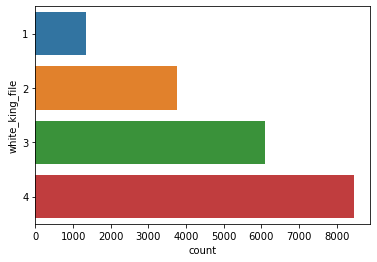

In [39]:
sns.countplot(y = "white_king_file", data = df_train.sort_values(by = "white_king_file"),orient="h")

<AxesSubplot:xlabel='count', ylabel='white_king_rank'>

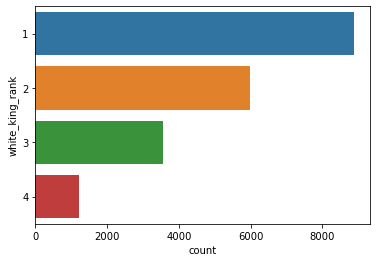

In [40]:
sns.countplot(y = "white_king_rank", data = df_train.sort_values(by = "white_king_rank"),orient="h")

Dwa powyższe rozkłady wydają się swoim lustrzanym odbiciem. Wychodzi, że biały król najczęściej znajdował się na polu __D1__.

<AxesSubplot:xlabel='count', ylabel='black_king_file'>

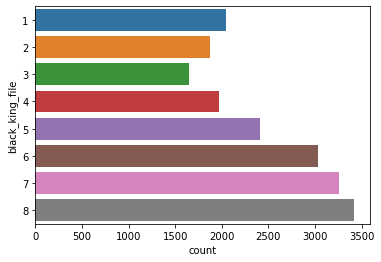

In [41]:
sns.countplot(y = "black_king_file", data = df_train.sort_values(by = "black_king_file"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black_king_rank'>

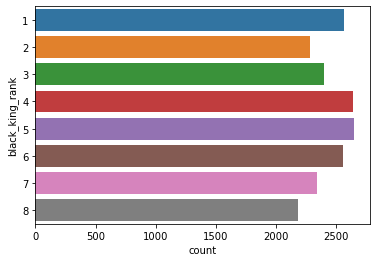

In [42]:
sns.countplot(y = "black_king_rank", data = df_train.sort_values(by = "black_king_rank"),orient="h")

<AxesSubplot:xlabel='count', ylabel='white_rook_rank'>

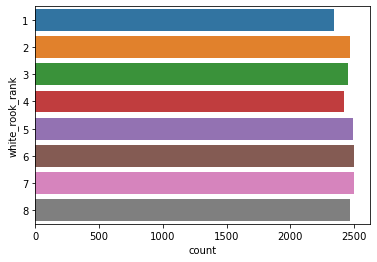

In [43]:
sns.countplot(y = "white_rook_rank", data = df_train.sort_values(by = "white_rook_rank"),orient="h")

<AxesSubplot:xlabel='count', ylabel='white_rook_file'>

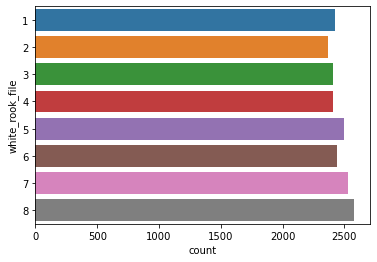

In [44]:
sns.countplot(y = "white_rook_file", data = df_train.sort_values(by = "white_rook_file"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black_king_dst'>

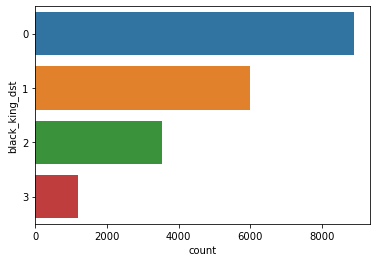

In [45]:
sns.countplot(y = "black_king_dst", data = df_train.sort_values(by = "black_king_dst"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black2white_king_dst'>

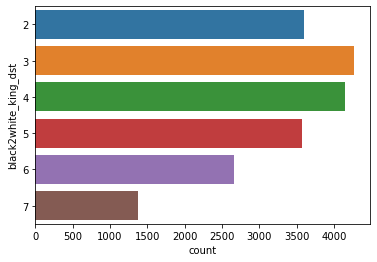

In [46]:
sns.countplot(y = "black2white_king_dst", data = df_train.sort_values(by = "black2white_king_dst"),orient="h")

<AxesSubplot:xlabel='count', ylabel='black2rook_dst'>

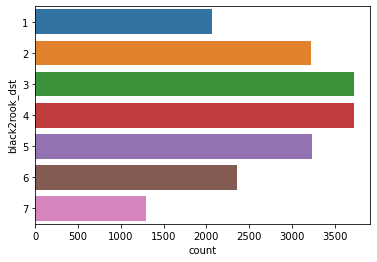

In [47]:
sns.countplot(y = "black2rook_dst", data = df_train.sort_values(by = "black2rook_dst"),orient="h")

<AxesSubplot:xlabel='result', ylabel='Count'>

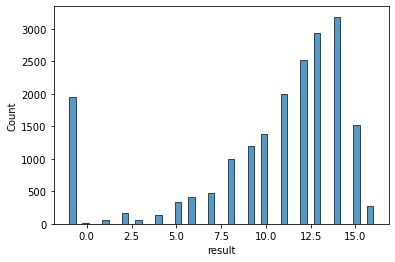

In [51]:
sns.histplot(x = "result", data = df_train)

Widać, że w zbiorze danych zwykle do mata potrzeba było więcej ruchów. Pierwsza kolumna na wykresie oznacza liczbę remisów.

Analiza dwuwymiarowa:

In [52]:
df_train.corr()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result,black_king_dst,black2white_king_dst,black2rook_dst
white_king_file,1.000000,0.456087,-0.009108,0.000182,-0.140401,0.105595,-0.195264,-0.054697,-0.297172,0.025093
white_king_rank,0.456087,1.000000,0.008568,-0.008044,0.097899,-0.123493,-0.247554,-0.095732,-0.358309,0.036792
white_rook_file,-0.009108,0.008568,1.000000,-0.008674,-0.015768,-0.001490,-0.056035,0.013431,-0.016254,-0.132705
white_rook_rank,0.000182,-0.008044,-0.008674,1.000000,0.004017,-0.025332,0.001758,-0.008814,-0.004573,0.020399
black_king_file,-0.140401,0.097899,-0.015768,0.004017,1.000000,-0.075550,0.044304,-0.069412,0.268161,0.020694
black_king_rank,0.105595,-0.123493,-0.001490,-0.025332,-0.075550,1.000000,0.216334,0.027861,0.611104,-0.022466
result,-0.195264,-0.247554,-0.056035,0.001758,0.044304,0.216334,1.000000,0.230134,0.152326,0.350126
black_king_dst,-0.054697,-0.095732,0.013431,-0.008814,-0.069412,0.027861,0.230134,1.000000,-0.358527,-0.322727
black2white_king_dst,-0.297172,-0.358309,-0.016254,-0.004573,0.268161,0.611104,0.152326,-0.358527,1.000000,0.124789
black2rook_dst,0.025093,0.036792,-0.132705,0.020399,0.020694,-0.022466,0.350126,-0.322727,0.124789,1.000000


<AxesSubplot:>

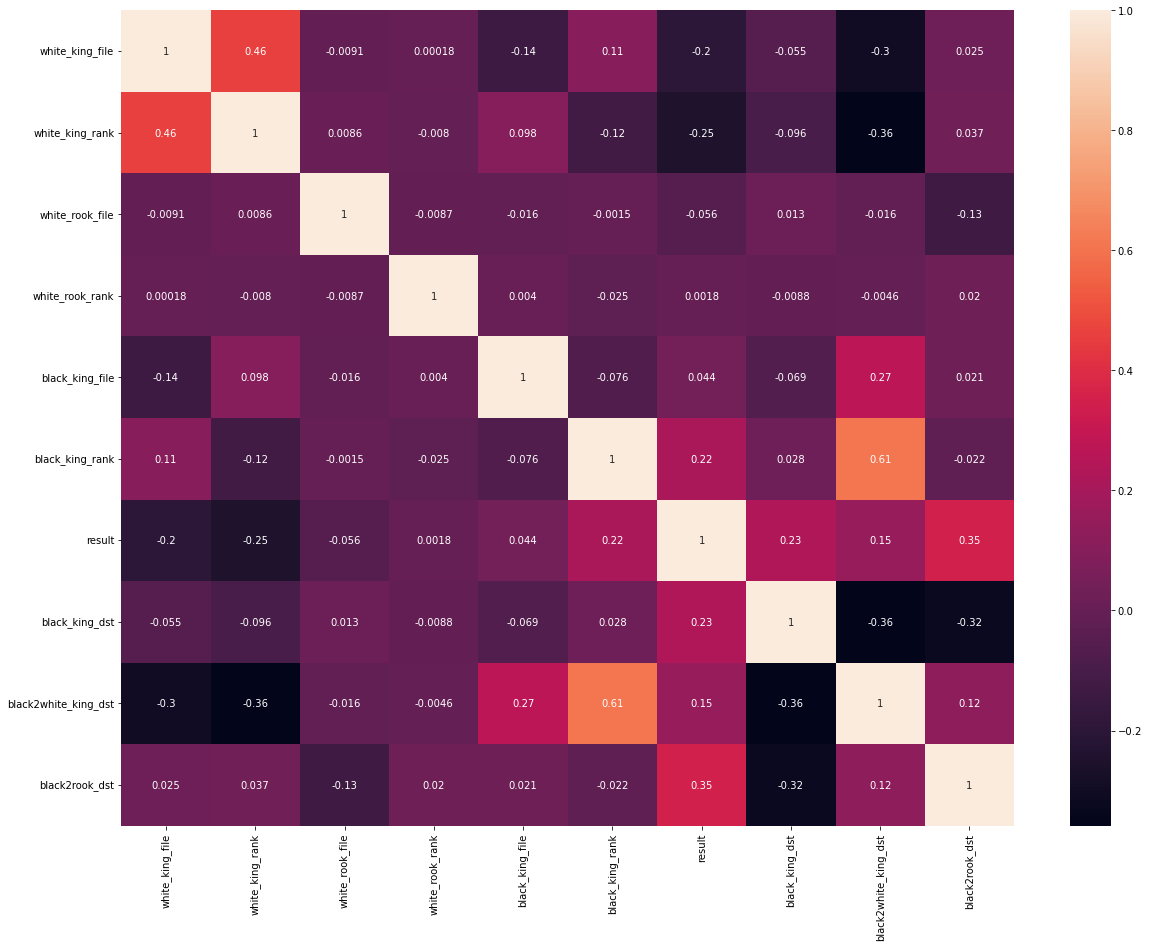

In [53]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df_train.corr(),annot=True)

Z wykresu widać, że żadne zmienne nie mają wystarczająco dużej korelacji, abyśmy musieli je usuwać. Zmienna _result_ ma dosyć dobrą korelację z kilkoma zminnymi, między innymi dobre wartości są z kolumnami, które utworzyliśmy. Ciekawym spostrzeżeniem jest różnica w korelacji pomiędzy zmiennymi _black_king_file_ i _black_king_rank_, a zmienną _result_. Wygląda na to, że większość graczy woli matować do jednej z poziomych krawędzi planszy.


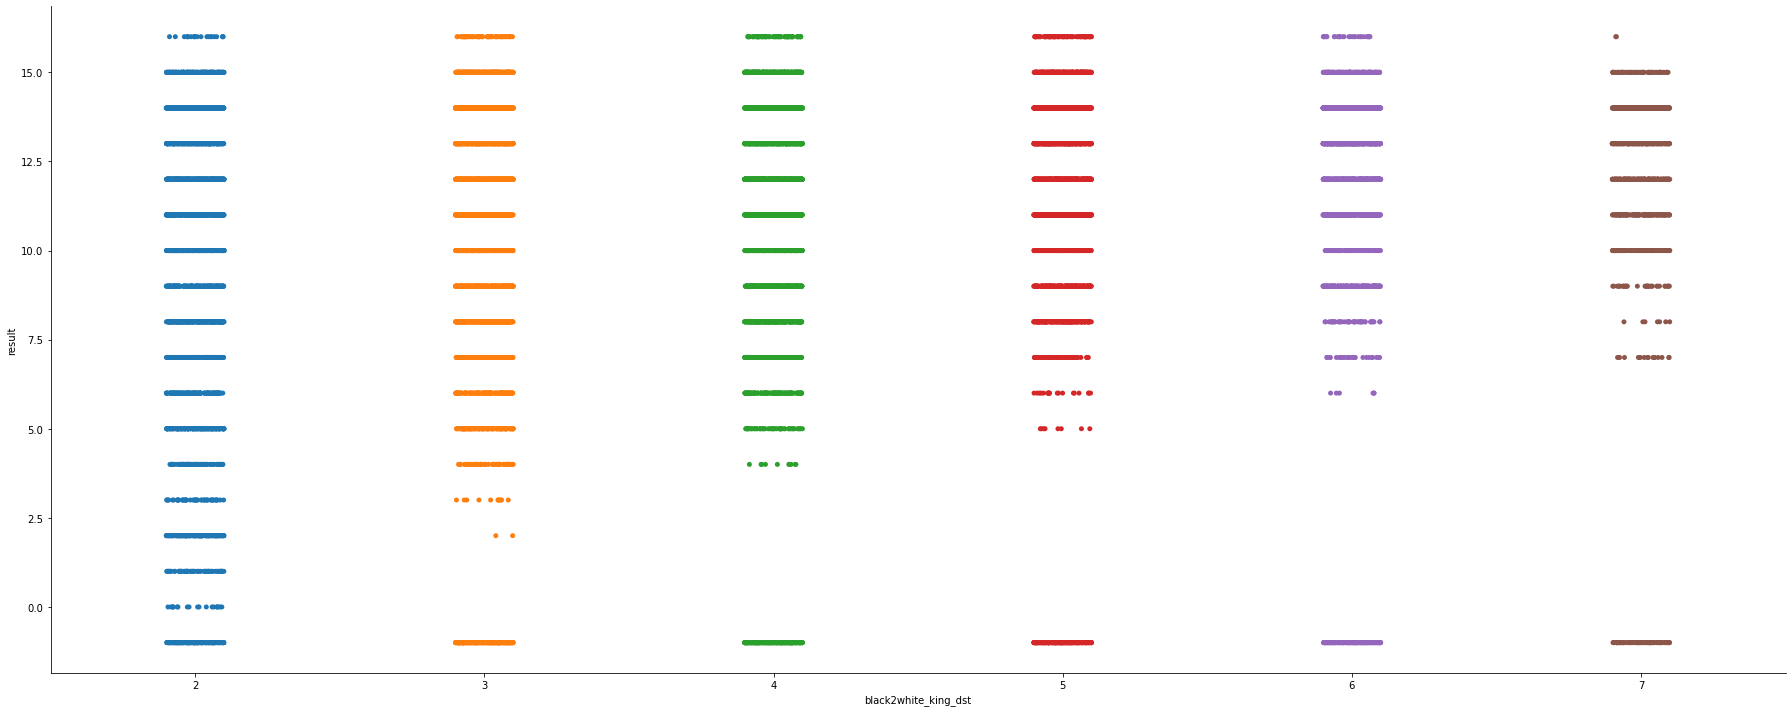

In [55]:
sns.catplot(x="black2white_king_dst", y="result", data=df_train,height=10,aspect=2.5)

Próbowaliśmy zobaczyć jak się ma gęstość ilości ruchów potrzebnych do mata względem odległości pomiędzy królami, ale wykres nie okazał się najlepszy. Jedyne co można zauważyć to, że im większa startowa odległość między królami, tym więcej ruchów potrzeba na mata. Jest to zrozumiałe, poniważ do mata króle powinny być obok siebie.  